## Imports:

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly
import plotly.offline as py
import math
from pingouin import partial_corr
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from dask.distributed import Client
import itertools

## Prepare the data:

In [2]:
data = pd.read_csv ('Compiled.csv')
data = data.rename(columns={'datetime': 'ds','load': 'y'})
data['ds'] = pd.to_datetime(data['ds'])

# regressors = ['pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f',
#                      'month', 'hour', 'type_of_day', 'day', ' year', 'covid'
#                     ]
regressors = ['pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f']

# columns = ['y', 'ds', 'pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f', 
#                      'month', 'hour', 'type_of_day', 'day', ' year', 'covid'
#                     ]
columns = ['y', 'ds', 'pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f'] 

/var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/ipykernel_32540/3081521635.py:3: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



## Helper functions: lags, plotting, error measures

In [12]:
def calculate_lags(data):
    # Create lagged features for load
    num_lags = 168  # Number of past lags
    for i in range(1, num_lags + 1):
        data[f'ds_lag_{i}'] = data['y'].shift(i)
        
    data.head()

    # Drop rows with missing values due to lagging
    data.dropna(inplace=True)

    # Calculate partial correlations between load and lagged load variables
    lagged_columns = [f'ds_lag_{i}' for i in range(1, num_lags + 1)]
    partial_correlations = {}
    for lag_column in lagged_columns:
        other_columns = [col for col in lagged_columns if col != lag_column]
        data_temp = data[[lag_column, 'y'] + other_columns]
        partial_corr_result = partial_corr(data_temp, x=lag_column, y='y', covar=other_columns, method='pearson')
        partial_correlation = partial_corr_result['r'][0]
        partial_correlations[lag_column] = partial_correlation

    # Select lags with partial correlations above a certain threshold
    threshold = 0.05  # You can adjust this threshold
    selected_lags = [lag for lag, corr in partial_correlations.items() if abs(corr) > threshold]
    
    return data, selected_lags

def make_plot(targets, predictions):
    plt.figure(figsize=(18,10 ))
    plt.plot(targets['ds'], targets['y'], color='blue', label='actual', linewidth=0.7)
    plt.plot(predictions['ds'], predictions['yhat'], color='red', label='predicted', linewidth=0.5)
    plt.legend()
    
    
def calculate_mae(actual, predicted):
    n = len(actual)
    sum = 0
    for i in range(n):
        sum += abs(actual[i] - predicted[i])
        
    error = sum/n
    return round(error, 3)

def calculate_mape(actual, predicted):
    APE = []
    n = len(actual)
    # Iterate over the list values
    for i in range(n):
        # Calculate percentage error
        per_err = (actual[i] - predicted[i]) / actual[i]
        per_err = abs(per_err)
        # Append it to the APE list
        APE.append(per_err)
    # Calculate the MAPE
    MAPE = sum(APE)/len(APE) * 100
    return round(MAPE, 3)

def calculate_rmse(actual, predicted):
    return round(math.sqrt(mean_squared_error(actual, predicted)), 3)

def get_error_measures(actual, predicted):
    result = "MAE: " + str(calculate_mae(actual, predicted)) + "\n"
    result += "MAPE: " + str(calculate_mape(actual, predicted)) + "\n"
    result += "RMSE: " + str(calculate_rmse(actual, predicted)) + "\n"
    return result

## Reusing parameters when fitting:

In [10]:
def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialize a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

## Backtesting using expanding window:

In [33]:
def run_backtest_extending(
    data,
    columns, 
    regs,
    start_window,
    retrain_frequency, 
    model = Prophet(interval_width=0.95, changepoint_range=0.8),
    horizon = 48
):
    """Simple backtesting implementation.
    
    Args:
        model: A model with fit and predict methods.
        targets: Series with the target in chronological order.
        features: Dataframe with the features in chronological order.
        start_window: The initial window to train a model.
        retrain_frequency: How often to retrain the model.
        
    Return:
        A dataframe with the validation target and prediction.
    """
        
    # add regressors to the model:
    for col in regs:
        model.add_regressor(col)
    #forecast columns:
    forecast_cols = regs + ['ds']
        
    
    all_preds = []
    all_targets = []
    last_timestep = start_window
    retraining_times = 0
    while last_timestep < len(data):
#         print("Last timestamp: " + str(last_timestep)+ "\n\n")
        # Split train/valid
        train = data[columns].iloc[:last_timestep].squeeze()
        valid = data[forecast_cols].iloc[last_timestep:last_timestep+horizon].squeeze()
        actual_y = data[['ds', 'y']].iloc[last_timestep:last_timestep+horizon]
    
        # Train the model
        if last_timestep==start_window or last_timestep % retrain_frequency == 0:
            model = Prophet(interval_width=0.95, changepoint_range=0.8)
            model.fit(train)
            print("last timestamp: " + str(last_timestep))
            retraining_times += 1
            
        # Predict on valid set
        pred_valid = model.predict(valid)[['ds', 'yhat']]
        
        # Save the output
#         all_preds.append(pred_valid[['ds', 'yhat']])
#         all_targets.append(actual_y)
        all_targets.append(actual_y)
        all_preds.append(pred_valid)

        # Process next timestep
        last_timestep += horizon
        
    print("retrained: " + str(retraining_times))
    return all_preds, all_targets

In [38]:
#window is 3 months (3 * 30 * 24)
# 7 means every 7 days
# every 3 months means (3 * 30 * 24) // 48
frequency = 45
window = 2160

all_preds, all_targets = run_backtest_extending(
    data,
    columns, 
    regressors,
    start_window = window,
    retrain_frequency = frequency)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 2160


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 2880


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 3600


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 4320


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 5040


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 5760


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 6480


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 7200


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 7920


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 8640


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 9360


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 10080


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 10800


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 11520


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 12240


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 12960


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 13680


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 14400


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 15120


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 15840


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 16560


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 17280


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 18000


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 18720


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 19440


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 20160


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 20880


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 21600


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 22320


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 23040


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 23760


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 24480


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 25200


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 25920


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 26640


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 27360


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 28080


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 28800


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 29520


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 30240


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 30960


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 31680


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 32400


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


last timestamp: 33120
retrained: 44


MAE: 65707.259
MAPE: 5.862
RMSE: 88195.971



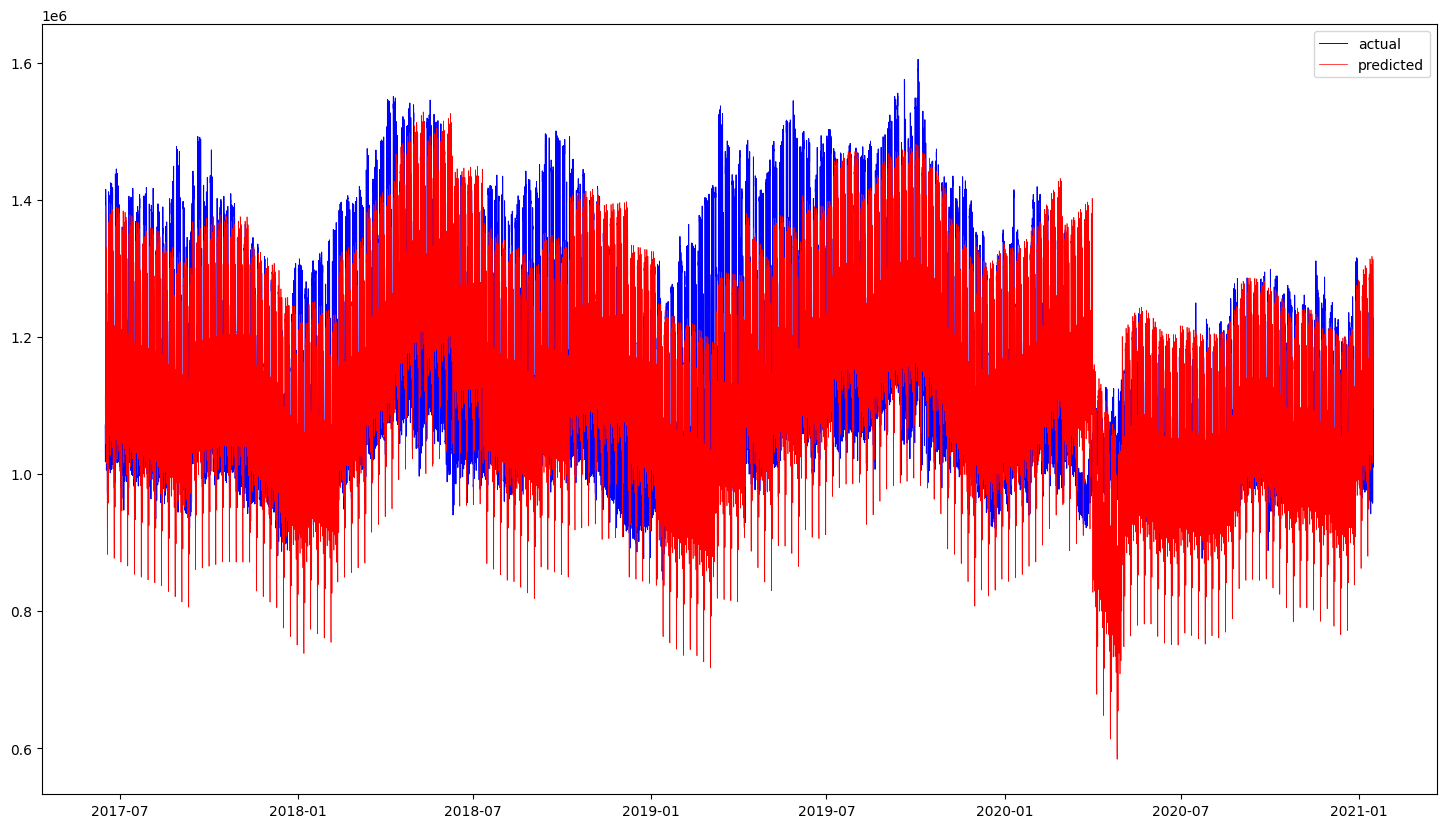

In [39]:
targets = pd.concat(all_targets)
predictions  = pd.concat(all_preds)
make_plot(targets, predictions)
print(get_error_measures(list(targets['y']), list(predictions['yhat'])))

## Backtesting using sliding window:

In [82]:
def run_backtest_sliding(
    data,
    columns, 
    regs,
    start_window,
    retrain_frequency, 
    model = Prophet(interval_width=0.95, changepoint_range=0.8),
    horizon = 48
):
    """Simple backtesting implementation.
    
    Args:
        model: A model with fit and predict methods.
        targets: Series with the target in chronological order.
        features: Dataframe with the features in chronological order.
        start_window: The initial window to train a model.
        retrain_frequency: How often to retrain the model.
        
    Return:
        A dataframe with the validation target and prediction.
    """
        
    # add regressors to the model:
    for col in regs:
        model.add_regressor(col)
    #forecast columns:
    forecast_cols = regs + ['ds']
        
    all_preds = []
    all_targets = []
    last_timestep = start_window
    first_timestep = 0
    retraining_times = 0
    while last_timestep < len(data):
        # Split train/valid

        train = data[columns].iloc[first_timestep:last_timestep].squeeze()
        valid = data[forecast_cols].iloc[last_timestep:last_timestep+horizon].squeeze()
        actual_y = data[['ds', 'y']].iloc[last_timestep:last_timestep+horizon]
    
                
        # Train the model
        if last_timestep==start_window or last_timestep % retrain_frequency == 0:
            model = Prophet(interval_width=0.95, changepoint_range=0.8)
            model.fit(train)
            retraining_times += 1
            first_timestep = last_timestep - start_window
            print("retraining. "+str(first_timestep)+ " to " + str(last_timestep))
            
        # Predict on valid set
        pred_valid = model.predict(valid)[['ds', 'yhat']]
        
        # Save the output
#         all_preds.append(pred_valid[['ds', 'yhat']])
#         all_targets.append(actual_y)
        all_targets.append(actual_y)
        all_preds.append(pred_valid)

        # Process next timestep
        last_timestep += horizon
        
    print(f"retrained {retraining_times} times.")
    return all_preds, all_targets

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 0 to 2160


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 48 to 2208


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 96 to 2256


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 144 to 2304


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 192 to 2352


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 240 to 2400


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 288 to 2448


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 336 to 2496


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 384 to 2544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 432 to 2592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 480 to 2640


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 528 to 2688


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 576 to 2736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 624 to 2784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 672 to 2832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 720 to 2880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 768 to 2928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 816 to 2976


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 864 to 3024


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 912 to 3072


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 960 to 3120


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1008 to 3168


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1056 to 3216


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1104 to 3264


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1152 to 3312


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1200 to 3360


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1248 to 3408


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1296 to 3456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1344 to 3504


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1392 to 3552


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1440 to 3600


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1488 to 3648


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1536 to 3696


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1584 to 3744


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1632 to 3792


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1680 to 3840


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1728 to 3888


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1776 to 3936


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1824 to 3984


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 1872 to 4032


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 1920 to 4080
retraining. 1968 to 4128


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2016 to 4176


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2064 to 4224


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2112 to 4272


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2160 to 4320


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 2208 to 4368


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2256 to 4416


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2304 to 4464


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2352 to 4512


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2400 to 4560


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2448 to 4608


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2496 to 4656


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2544 to 4704


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2592 to 4752


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2640 to 4800


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2688 to 4848


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2736 to 4896


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2784 to 4944


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2832 to 4992


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2880 to 5040


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2928 to 5088


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 2976 to 5136


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3024 to 5184


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3072 to 5232


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3120 to 5280


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3168 to 5328


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 3216 to 5376
retraining. 3264 to 5424


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3312 to 5472


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3360 to 5520


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3408 to 5568


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3456 to 5616


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3504 to 5664


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3552 to 5712


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3600 to 5760


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3648 to 5808


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3696 to 5856


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3744 to 5904


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3792 to 5952


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3840 to 6000


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3888 to 6048


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3936 to 6096


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 3984 to 6144


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4032 to 6192


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4080 to 6240


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4128 to 6288


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4176 to 6336


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4224 to 6384


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4272 to 6432


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4320 to 6480


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4368 to 6528


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4416 to 6576


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4464 to 6624


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4512 to 6672


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4560 to 6720


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4608 to 6768


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4656 to 6816


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4704 to 6864


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4752 to 6912


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4800 to 6960


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4848 to 7008


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4896 to 7056


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4944 to 7104


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 4992 to 7152


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5040 to 7200


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5088 to 7248


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5136 to 7296


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5184 to 7344


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5232 to 7392


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5280 to 7440


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 5328 to 7488
retraining. 5376 to 7536


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5424 to 7584


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5472 to 7632


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5520 to 7680


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5568 to 7728


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 5616 to 7776
retraining. 5664 to 7824


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5712 to 7872


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5760 to 7920


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5808 to 7968


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5856 to 8016


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5904 to 8064


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 5952 to 8112


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6000 to 8160


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6048 to 8208


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6096 to 8256


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6144 to 8304


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6192 to 8352


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6240 to 8400


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6288 to 8448


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6336 to 8496


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6384 to 8544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6432 to 8592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6480 to 8640


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6528 to 8688


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6576 to 8736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6624 to 8784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6672 to 8832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6720 to 8880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6768 to 8928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6816 to 8976


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6864 to 9024


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6912 to 9072


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 6960 to 9120


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7008 to 9168
retraining. 7056 to 9216


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7104 to 9264
retraining. 7152 to 9312


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7200 to 9360
retraining. 7248 to 9408


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7296 to 9456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7344 to 9504
retraining. 7392 to 9552


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7440 to 9600


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7488 to 9648


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7536 to 9696


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7584 to 9744
retraining. 7632 to 9792


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 7680 to 9840
retraining. 7728 to 9888


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7776 to 9936


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7824 to 9984


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7872 to 10032


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7920 to 10080


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 7968 to 10128


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8016 to 10176


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8064 to 10224


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8112 to 10272


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8160 to 10320


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8208 to 10368


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8256 to 10416


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8304 to 10464


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8352 to 10512


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8400 to 10560


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8448 to 10608


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8496 to 10656


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8544 to 10704


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8592 to 10752


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8640 to 10800


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8688 to 10848


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8736 to 10896


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8784 to 10944


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8832 to 10992


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8880 to 11040


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8928 to 11088


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 8976 to 11136


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 9024 to 11184
retraining. 9072 to 11232


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9120 to 11280


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9168 to 11328


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9216 to 11376


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9264 to 11424


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9312 to 11472


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9360 to 11520


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9408 to 11568


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9456 to 11616


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9504 to 11664


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9552 to 11712


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9600 to 11760


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9648 to 11808


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9696 to 11856


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9744 to 11904


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 9792 to 11952


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9840 to 12000


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9888 to 12048


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9936 to 12096


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 9984 to 12144


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10032 to 12192


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10080 to 12240


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10128 to 12288


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10176 to 12336


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10224 to 12384


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 10272 to 12432
retraining. 10320 to 12480


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10368 to 12528


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10416 to 12576


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10464 to 12624


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10512 to 12672


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10560 to 12720


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10608 to 12768


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 10656 to 12816


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 10704 to 12864
retraining. 10752 to 12912


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 10800 to 12960
retraining. 10848 to 13008


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 10896 to 13056
retraining. 10944 to 13104


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


retraining. 10992 to 13152
retraining. 11040 to 13200


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11088 to 13248


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11136 to 13296


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11184 to 13344
retraining. 11232 to 13392


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11280 to 13440
retraining. 11328 to 13488


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11376 to 13536
retraining. 11424 to 13584


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11472 to 13632


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11520 to 13680


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11568 to 13728


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11616 to 13776
retraining. 11664 to 13824


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11712 to 13872
retraining. 11760 to 13920


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11808 to 13968


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11856 to 14016


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 11904 to 14064


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 11952 to 14112


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 12000 to 14160
retraining. 12048 to 14208


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 12096 to 14256
retraining. 12144 to 14304


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 12192 to 14352
retraining. 12240 to 14400


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 12288 to 14448
retraining. 12336 to 14496


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12384 to 14544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12432 to 14592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 12480 to 14640
retraining. 12528 to 14688


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12576 to 14736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12624 to 14784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12672 to 14832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12720 to 14880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12768 to 14928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12816 to 14976


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12864 to 15024


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12912 to 15072


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 12960 to 15120


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13008 to 15168


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13056 to 15216


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13104 to 15264


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13152 to 15312


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13200 to 15360


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13248 to 15408


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13296 to 15456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13344 to 15504


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13392 to 15552


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13440 to 15600


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13488 to 15648


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13536 to 15696


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13584 to 15744


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13632 to 15792


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 13680 to 15840
retraining. 13728 to 15888


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13776 to 15936


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13824 to 15984


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13872 to 16032


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13920 to 16080


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 13968 to 16128


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14016 to 16176


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14064 to 16224


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14112 to 16272


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14160 to 16320


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14208 to 16368


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14256 to 16416


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14304 to 16464


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14352 to 16512


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14400 to 16560


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14448 to 16608


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14496 to 16656


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14544 to 16704


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14592 to 16752


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14640 to 16800


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14688 to 16848


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14736 to 16896


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14784 to 16944


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14832 to 16992


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14880 to 17040


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14928 to 17088


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 14976 to 17136


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15024 to 17184


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15072 to 17232


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15120 to 17280


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15168 to 17328


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15216 to 17376


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15264 to 17424


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15312 to 17472


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15360 to 17520


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15408 to 17568


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15456 to 17616


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15504 to 17664


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15552 to 17712


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15600 to 17760


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15648 to 17808


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15696 to 17856


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15744 to 17904


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15792 to 17952


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15840 to 18000


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15888 to 18048


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15936 to 18096


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 15984 to 18144


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16032 to 18192


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16080 to 18240


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16128 to 18288


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16176 to 18336


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16224 to 18384


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16272 to 18432


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16320 to 18480


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16368 to 18528


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16416 to 18576


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16464 to 18624


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16512 to 18672


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16560 to 18720


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16608 to 18768


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16656 to 18816


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16704 to 18864


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16752 to 18912


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16800 to 18960


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16848 to 19008


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16896 to 19056


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16944 to 19104


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 16992 to 19152


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17040 to 19200


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17088 to 19248


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17136 to 19296


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17184 to 19344


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17232 to 19392


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17280 to 19440


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17328 to 19488


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17376 to 19536


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17424 to 19584


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17472 to 19632


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17520 to 19680


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17568 to 19728


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17616 to 19776


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17664 to 19824


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17712 to 19872


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17760 to 19920


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17808 to 19968


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17856 to 20016


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17904 to 20064


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 17952 to 20112


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 18000 to 20160
retraining. 18048 to 20208


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18096 to 20256


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 18144 to 20304
retraining. 18192 to 20352


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18240 to 20400


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 18288 to 20448


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18336 to 20496


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18384 to 20544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18432 to 20592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18480 to 20640


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18528 to 20688


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18576 to 20736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18624 to 20784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18672 to 20832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18720 to 20880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 18768 to 20928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 18816 to 20976
retraining. 18864 to 21024


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 18912 to 21072
retraining. 18960 to 21120


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19008 to 21168


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 19056 to 21216
retraining. 19104 to 21264


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19152 to 21312


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19200 to 21360


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19248 to 21408


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19296 to 21456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19344 to 21504


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19392 to 21552


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19440 to 21600


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19488 to 21648


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19536 to 21696


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19584 to 21744


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19632 to 21792


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19680 to 21840


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19728 to 21888


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19776 to 21936


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19824 to 21984


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19872 to 22032


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 19920 to 22080


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 19968 to 22128
retraining. 20016 to 22176


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


retraining. 20064 to 22224
retraining. 20112 to 22272


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20160 to 22320


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20208 to 22368


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20256 to 22416


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20304 to 22464


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20352 to 22512


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20400 to 22560


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20448 to 22608


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20496 to 22656


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20544 to 22704


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20592 to 22752


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20640 to 22800


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20688 to 22848


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20736 to 22896


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20784 to 22944


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20832 to 22992


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20880 to 23040


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20928 to 23088


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 20976 to 23136


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21024 to 23184


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21072 to 23232


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21120 to 23280


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21168 to 23328


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21216 to 23376


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21264 to 23424


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21312 to 23472


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21360 to 23520


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21408 to 23568


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21456 to 23616


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21504 to 23664


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21552 to 23712


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21600 to 23760


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21648 to 23808


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21696 to 23856


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21744 to 23904


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21792 to 23952


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21840 to 24000


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21888 to 24048


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21936 to 24096


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 21984 to 24144


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22032 to 24192


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22080 to 24240


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22128 to 24288


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22176 to 24336


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22224 to 24384


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22272 to 24432


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22320 to 24480


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22368 to 24528


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22416 to 24576


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22464 to 24624


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22512 to 24672


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22560 to 24720


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22608 to 24768


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22656 to 24816


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22704 to 24864


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22752 to 24912


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22800 to 24960


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22848 to 25008


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22896 to 25056


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22944 to 25104


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 22992 to 25152


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23040 to 25200


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23088 to 25248


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23136 to 25296


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23184 to 25344


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23232 to 25392


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23280 to 25440


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23328 to 25488


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23376 to 25536


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23424 to 25584


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23472 to 25632


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23520 to 25680


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23568 to 25728


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23616 to 25776


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23664 to 25824


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23712 to 25872


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23760 to 25920


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23808 to 25968


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23856 to 26016


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23904 to 26064


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 23952 to 26112


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24000 to 26160


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24048 to 26208


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24096 to 26256


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24144 to 26304


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24192 to 26352


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24240 to 26400


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24288 to 26448


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24336 to 26496


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24384 to 26544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24432 to 26592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24480 to 26640


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24528 to 26688


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24576 to 26736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24624 to 26784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24672 to 26832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24720 to 26880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24768 to 26928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24816 to 26976


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24864 to 27024


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24912 to 27072


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 24960 to 27120


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25008 to 27168


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25056 to 27216


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25104 to 27264


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25152 to 27312


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25200 to 27360


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25248 to 27408


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25296 to 27456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25344 to 27504


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25392 to 27552


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25440 to 27600


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25488 to 27648


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25536 to 27696


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25584 to 27744


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25632 to 27792


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25680 to 27840


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25728 to 27888


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25776 to 27936


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25824 to 27984


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25872 to 28032


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25920 to 28080


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 25968 to 28128


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26016 to 28176


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26064 to 28224


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26112 to 28272


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26160 to 28320


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26208 to 28368


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26256 to 28416


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26304 to 28464


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26352 to 28512


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26400 to 28560


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26448 to 28608


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26496 to 28656


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26544 to 28704


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26592 to 28752


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26640 to 28800


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26688 to 28848


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26736 to 28896


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26784 to 28944


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26832 to 28992


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26880 to 29040


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26928 to 29088


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 26976 to 29136


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27024 to 29184


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27072 to 29232


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27120 to 29280


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27168 to 29328


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27216 to 29376


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27264 to 29424


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27312 to 29472


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27360 to 29520


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27408 to 29568


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27456 to 29616


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27504 to 29664


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27552 to 29712


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27600 to 29760


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27648 to 29808


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27696 to 29856


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27744 to 29904


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27792 to 29952


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27840 to 30000


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27888 to 30048


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27936 to 30096


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 27984 to 30144


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28032 to 30192


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28080 to 30240


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28128 to 30288


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28176 to 30336


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28224 to 30384


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28272 to 30432


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28320 to 30480


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28368 to 30528


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28416 to 30576


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28464 to 30624


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28512 to 30672


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28560 to 30720


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28608 to 30768


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28656 to 30816


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28704 to 30864


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28752 to 30912


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28800 to 30960


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28848 to 31008


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28896 to 31056


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28944 to 31104


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 28992 to 31152


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29040 to 31200


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29088 to 31248


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29136 to 31296


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29184 to 31344


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29232 to 31392


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29280 to 31440


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29328 to 31488


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29376 to 31536


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29424 to 31584


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29472 to 31632


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29520 to 31680


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29568 to 31728


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29616 to 31776


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29664 to 31824


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29712 to 31872


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29760 to 31920


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29808 to 31968


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29856 to 32016


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29904 to 32064


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 29952 to 32112


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30000 to 32160


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30048 to 32208


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30096 to 32256


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30144 to 32304


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30192 to 32352


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30240 to 32400


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30288 to 32448


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30336 to 32496


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30384 to 32544


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30432 to 32592


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30480 to 32640


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30528 to 32688


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30576 to 32736


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30624 to 32784


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30672 to 32832


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30720 to 32880


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30768 to 32928


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30816 to 32976


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30864 to 33024


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30912 to 33072


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 30960 to 33120


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31008 to 33168


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31056 to 33216


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31104 to 33264


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31152 to 33312


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31200 to 33360


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31248 to 33408


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31296 to 33456


INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


retraining. 31344 to 33504


INFO:cmdstanpy:finish chain 1


retraining. 31392 to 33552
retrained 655 times.
MAE: 46550.173
MAPE: 4.124
RMSE: 62481.278



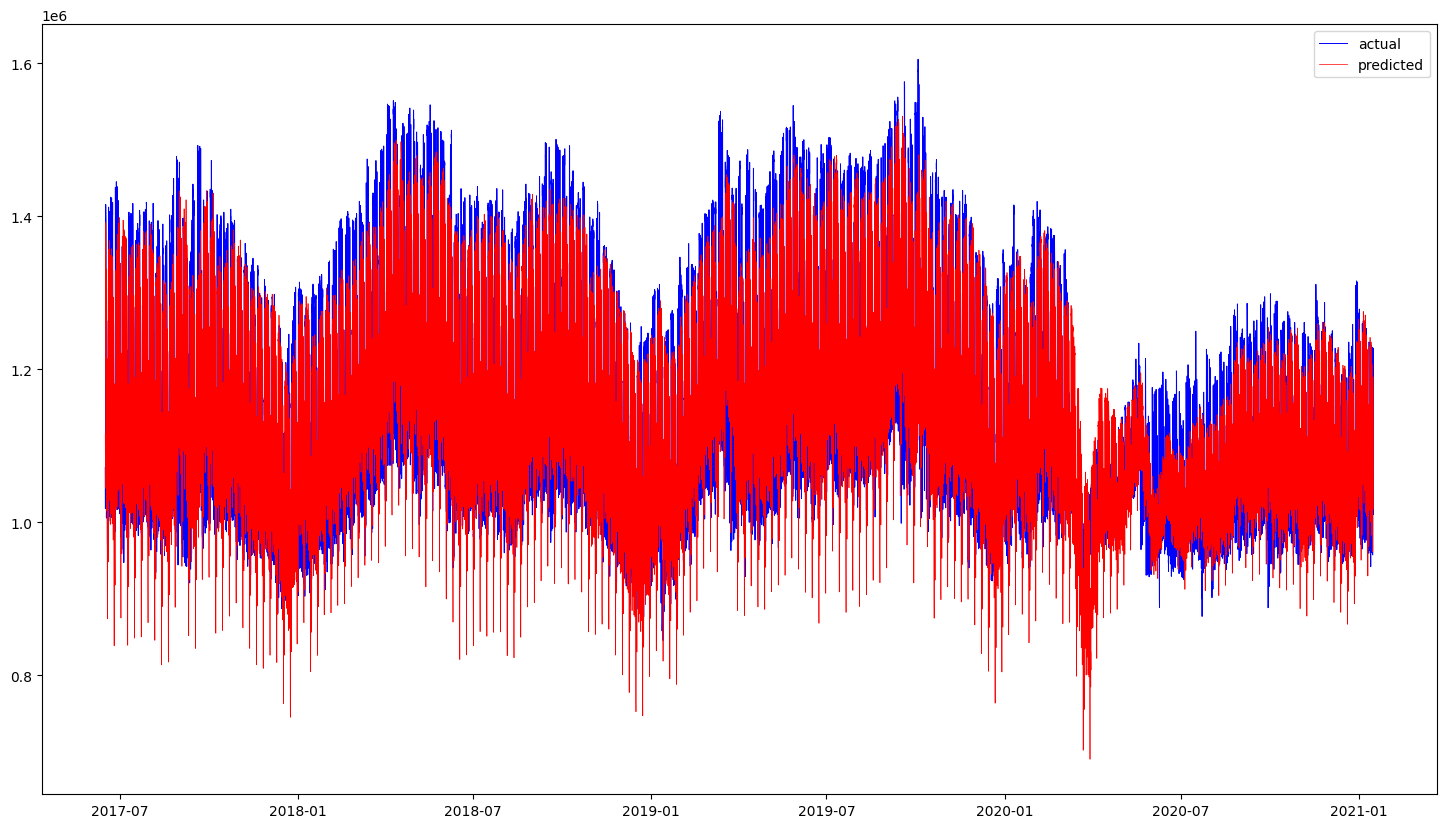

In [94]:
#window is 3 months (3 * 30 * 24)
# 7 means every 7 days
# every 3 months means (3 * 30 * 24) // 48
frequency = 48
window = 2160

all_preds, all_targets = run_backtest_sliding(data,columns, regressors,start_window = window,retrain_frequency = frequency)

targets = pd.concat(all_targets)
predictions  = pd.concat(all_preds)
make_plot(targets, predictions)
print(get_error_measures(list(targets['y']), list(predictions['yhat'])))

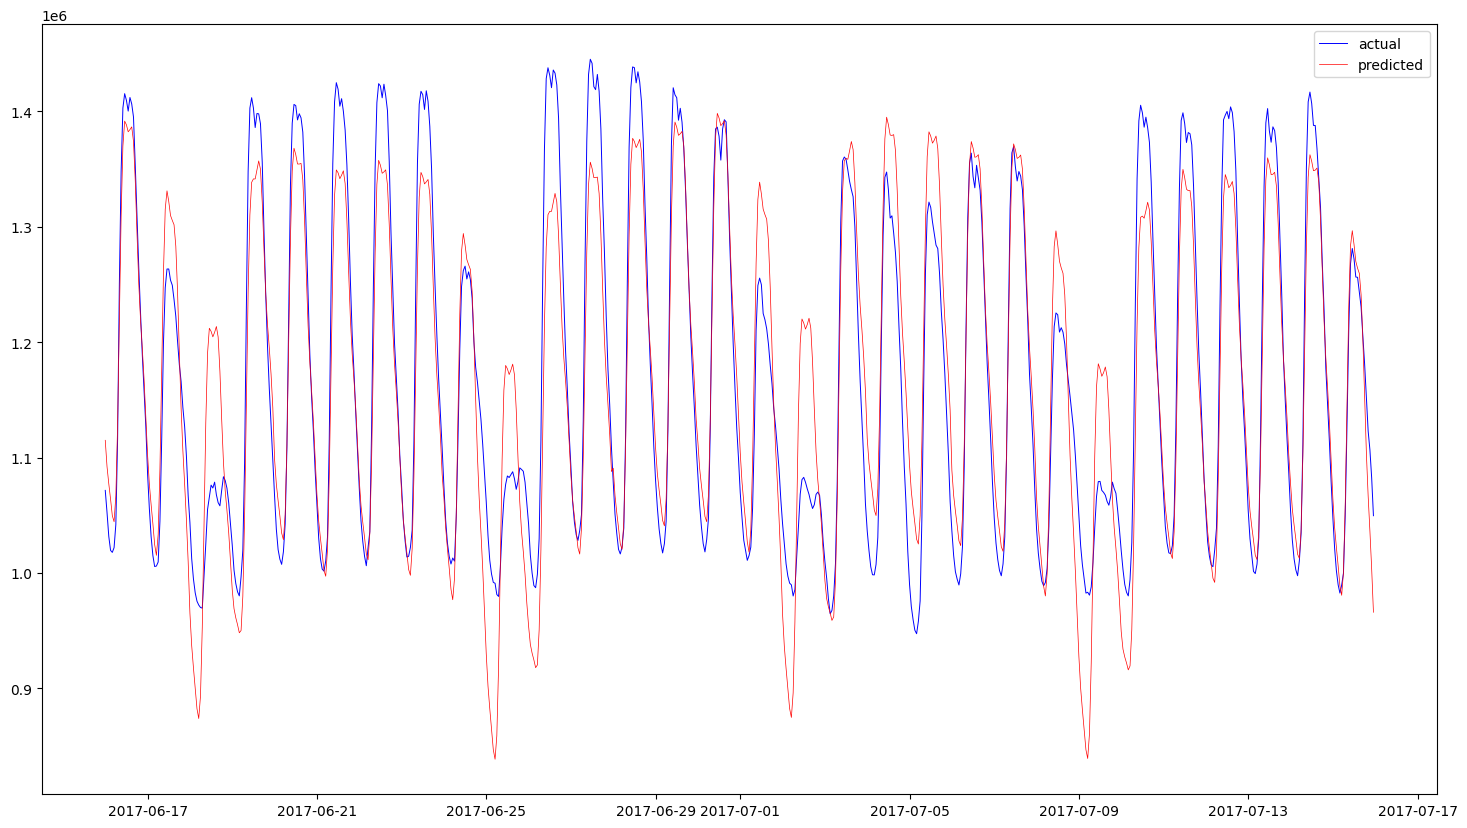

In [101]:
make_plot(targets[:30*24], predictions[:30*24])

## Prophet cross-validation:

In [145]:
model = Prophet(changepoint_prior_scale= 0.01,
 seasonality_prior_scale = 0.01,
 seasonality_mode = 'additive',
 changepoint_range = 0.9)
for col in regressors:
    model.add_regressor(col)
model.fit(data[columns])
df_cv = cross_validation(m, initial='90 days', horizon='2 days', period='2 days', parallel="processes")

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 17:20:35,919 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,053 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,176 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,300 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,431 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,556 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,680 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:36,816 - distr

2023-09-02 17:20:43,962 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,092 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,218 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,343 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,479 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,605 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,735 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:44,866 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 17:20:52,129 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,254 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,386 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,516 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,637 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,772 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:52,904 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 17:20:53,029 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgdmz3mrm
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpud56u9b3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmppqytww8l
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpc_qpg2ee
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu9h7uka3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp26npy8be
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpyvb3l4fm
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp8kgg18hw
done


In [146]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-06-18 00:00:00,9.860533e+05,914077.785441,1.061453e+06,1.043576e+06,2017-06-17 23:00:00
1,2017-06-18 01:00:00,9.611224e+05,885605.886198,1.035270e+06,1.012509e+06,2017-06-17 23:00:00
2,2017-06-18 02:00:00,9.463358e+05,870276.481457,1.019068e+06,9.947383e+05,2017-06-17 23:00:00
3,2017-06-18 03:00:00,9.313648e+05,853660.046761,1.008803e+06,9.827611e+05,2017-06-17 23:00:00
4,2017-06-18 04:00:00,9.085251e+05,831682.278717,9.830266e+05,9.755236e+05,2017-06-17 23:00:00
...,...,...,...,...,...,...
31387,2021-01-15 19:00:00,1.074079e+06,975872.651002,1.170414e+06,1.141079e+06,2021-01-13 23:00:00
31388,2021-01-15 20:00:00,1.044511e+06,958345.751369,1.133214e+06,1.108896e+06,2021-01-13 23:00:00
31389,2021-01-15 21:00:00,1.021126e+06,934204.723974,1.117093e+06,1.078978e+06,2021-01-13 23:00:00
31390,2021-01-15 22:00:00,9.952169e+05,904291.159664,1.087416e+06,1.044495e+06,2021-01-13 23:00:00


In [147]:
merged_df = data.merge(df_cv, on='ds', how='inner')

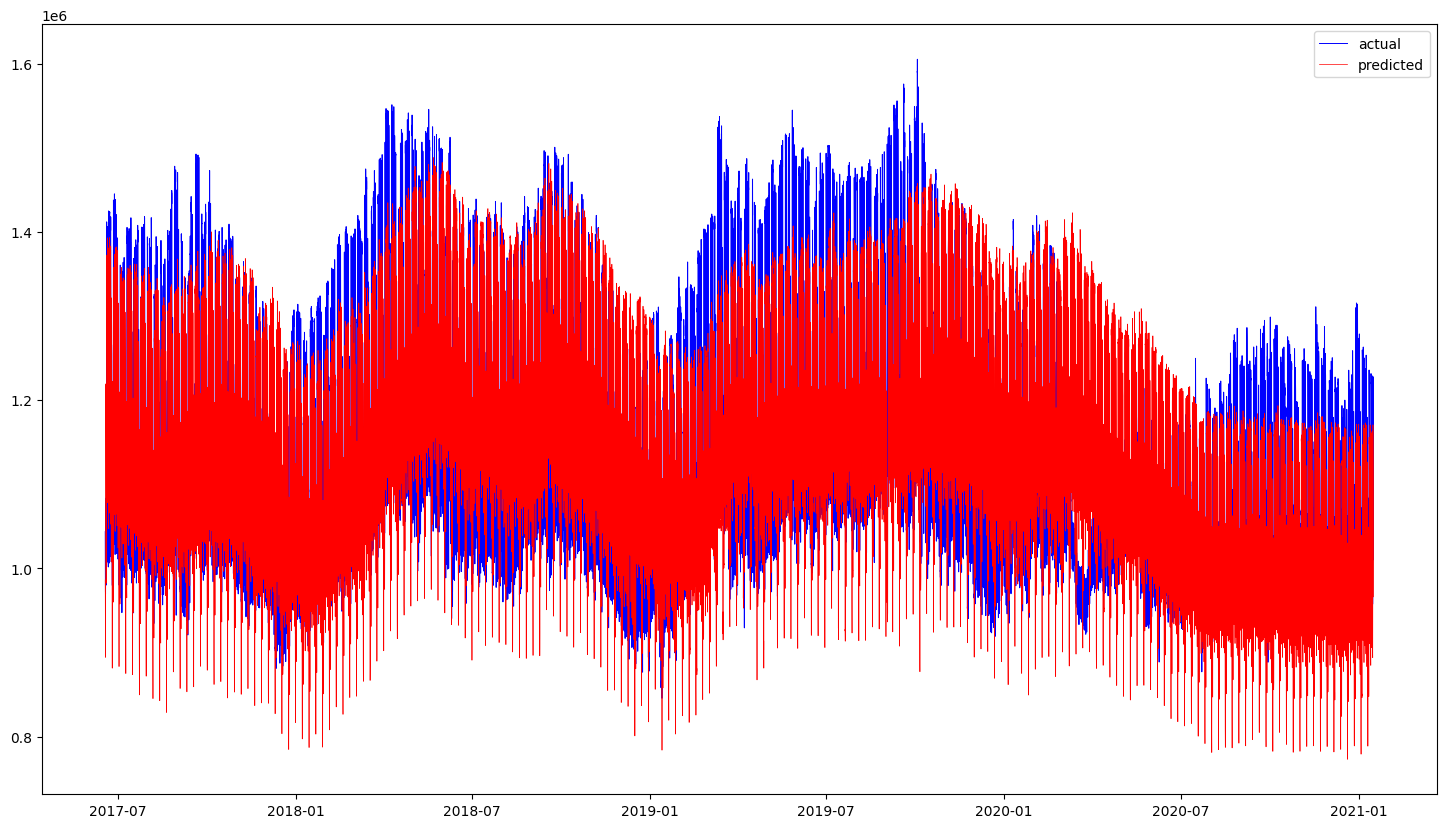

In [148]:
plt.figure(figsize=(18,10 ))
plt.plot(merged_df['ds'], merged_df['y_x'], color='blue', label='actual', linewidth=0.7)
plt.plot(merged_df['ds'], merged_df['yhat'], color='red', label='predicted', linewidth=0.5)
plt.legend()

In [149]:
df_p = performance_metrics(df_cv)

In [150]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,44,4.400000e+01,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,1 days 02:30:00,6.988085e+09,82309.362442,63608.416325,0.056413,0.045547,0.055780,0.726759
std,0 days 12:50:42.837283194,2.493677e+09,14772.040442,10574.822689,0.006129,0.004522,0.005270,0.072066
min,0 days 05:00:00,4.288672e+09,65487.955262,51681.744771,0.046754,0.037224,0.046821,0.614107
25%,0 days 15:45:00,4.662100e+09,68279.437744,54359.019171,0.051891,0.042362,0.052217,0.652084
50%,1 days 02:30:00,6.167426e+09,78504.669680,59625.939216,0.054678,0.046005,0.055398,0.758187
75%,1 days 13:15:00,9.544585e+09,97696.069068,74538.173426,0.062405,0.050162,0.060883,0.790522
max,2 days 00:00:00,1.066420e+10,103267.632330,79764.172953,0.065655,0.052032,0.063666,0.809507


## Grid Search:

In [132]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'], 
    'changepoint_range': [0.6, 0.7, 0.8, 0.9]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, yearly_seasonality=False)
    for col in regressors:
        m.add_regressor(col)
    m.fit(data[columns])  # Fit model with given params
    df_cv = cross_validation(m, initial='90 days', horizon='2 days', period='2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results['mape'] = mapes
print(tuning_results)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 11:44:49,041 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,167 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,293 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,434 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,566 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,693 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,827 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:49,956 - distr

2023-09-02 11:44:57,688 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:57,835 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,097 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,254 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,396 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,528 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,662 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:44:58,792 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 11:45:06,754 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:45:06,907 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,070 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,201 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,331 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,474 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,606 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:45:07,737 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzztujk6b
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp98y93_tf
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpx8v_ir4a
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpv0q2zfng
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpeyrshwgw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpjguhy92h
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcfn8_5vp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpb4i4aih7
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 11:50:55,013 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,135 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,270 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,396 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,521 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,651 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,777 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:50:55,905 - distr

2023-09-02 11:51:03,161 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,286 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,418 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,544 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,672 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,811 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:03,938 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:04,070 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 11:51:11,391 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:11,525 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:11,651 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:11,782 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:11,913 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 11:51:12,034 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:51:12,169 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 11:51:12,300 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpotnplmd1
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdgqpzyt9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0mmmeat1
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpa5wk7us2
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpbwlz5jeu
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5e1qkqka
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpd_8uxikf
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcxnbxfym
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 11:57:30,993 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,119 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,246 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,382 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,513 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,644 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,783 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:31,914 - distr

2023-09-02 11:57:39,437 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:57:39,569 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:57:39,706 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 11:57:39,851 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:39,984 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:40,122 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:40,259 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:40,390 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 11:57:48,087 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,222 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,356 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,480 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,616 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,747 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:48,874 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 11:57:49,005 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvfxnffr0
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdf3kmju1
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp89yff7ef
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmps6ei6875
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpobahp4o_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpf35vk2__
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpa2unhhy6
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmph_lukn5c
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:04:27,090 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,235 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,376 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,508 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,649 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,789 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:04:27,917 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:04:28,059 - distr

2023-09-02 12:04:35,457 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:35,588 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:35,718 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:35,848 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:35,986 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:36,114 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:36,249 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:36,385 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:04:43,796 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:43,924 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,055 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,187 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,310 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,446 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,579 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:04:44,706 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish cha

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxamc729q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzldg2k_q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpp_nshb04
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgtmyzrg7
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpfky01ksr
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpywinmuc1
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzi4zgv4y
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0p4hv8zz
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:11:09,162 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,290 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,441 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,578 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,721 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,856 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:09,995 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:10,125 - distr

2023-09-02 12:11:17,902 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,080 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,218 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,360 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,487 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,618 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,748 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:18,872 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:11:26,727 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:26,871 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,022 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,156 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,301 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,445 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,581 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:11:27,718 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpanhxnsum
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgiril2kq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7wq01xt6
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwv5ppyq2
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmprqbg7ttz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvp7w6whm
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsqc1j5e9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5wtoja1b
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:17:17,860 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-09-02 12:17:17,991 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,117 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,240 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,373 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,505 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,631 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:18,762 - distr

2023-09-02 12:17:26,509 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:26,645 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:26,802 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:26,943 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:27,094 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:27,249 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:27,400 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:17:27,543 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:17:35,118 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,246 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,377 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,538 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,668 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,800 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:35,933 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:17:36,055 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgdnyg6iw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp8p0fzb6s
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvshd_qoo
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpqh7a_nia
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp9vimxfpg
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpbur1435n
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdt6yqqzq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpoiwxqycs
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:23:57,794 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 12:23:57,922 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,062 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,194 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,323 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,465 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,600 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:23:58,737 - distr

2023-09-02 12:24:06,781 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:06,909 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,043 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,171 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,298 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,435 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,562 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:07,695 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:24:15,842 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:24:15,982 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,120 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,257 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,396 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,523 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,664 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:24:16,800 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_xbbkf1t
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0luts7h3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp977dpzc5
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpkoulxmai
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpuj0lk3q9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0v941e2c
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxpyekoq8
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpmj53kyib
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:31:07,961 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,088 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,210 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,346 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,474 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,600 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,730 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:08,858 - distr

2023-09-02 12:31:16,072 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,198 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,324 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,456 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,583 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,710 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,846 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:16,973 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:31:24,440 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:24,569 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:24,705 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:24,832 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:24,969 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:25,106 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:25,232 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:31:25,372 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6wodvfez
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcgsvdxyz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp771i3bsh
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpag2i8jgf
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpespnhxq_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgtzmyq4w
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpusjr2j4n
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp093qrhwg
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:37:56,876 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,004 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,134 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,262 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,397 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,540 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,667 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:37:57,802 - distr

2023-09-02 12:38:05,279 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:05,415 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 12:38:05,552 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:05,686 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:05,835 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:05,996 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:06,123 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:06,266 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:38:13,703 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:13,839 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:13,964 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:14,105 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:14,240 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:14,372 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:14,510 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:38:14,638 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start cha

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpb5n0l6y5
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpi15fa9vw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpr01rp7lb
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpjf6mu8pq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpbz_untrm
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpx68039o8
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp4dkuidxo
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcs8_4ohu
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:43:41,093 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,219 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,352 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,486 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,615 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,750 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:41,885 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:42,010 - distr

2023-09-02 12:43:49,258 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:49,382 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:49,513 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:49,639 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:49,762 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:49,897 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:50,023 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:50,149 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:43:57,509 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:57,644 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:57,769 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:57,896 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:58,027 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:58,154 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:58,282 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:43:58,418 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp488p2xne
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7784x7sd
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpmil08reh
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp35dszvwn
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpp4q19rhu
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmptcmvfmhi
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5_bgtt2m
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgah6fj6x
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:49:56,376 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 12:49:56,507 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:56,633 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:56,763 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:56,891 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:57,013 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:57,145 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:49:57,270 - distr

2023-09-02 12:50:04,504 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:04,630 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:04,752 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:04,884 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:05,009 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:05,131 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:05,266 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:05,392 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:50:12,729 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:12,853 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:12,988 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:13,114 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:13,240 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:13,372 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:13,498 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:50:13,625 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish cha

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpc9z5af8q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpm_t0j94b
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6p299fb5
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7d55hgns
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp41iyyu87
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpe9ytzrgm
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpnvl5wd7s
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdrm6bxlq
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 12:56:05,305 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-09-02 12:56:05,428 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:05,558 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:05,684 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:05,806 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:05,943 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:06,068 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:06,194 - distr

2023-09-02 12:56:13,421 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:13,543 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:13,677 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:13,803 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:13,930 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:14,060 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:14,187 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:14,313 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 12:56:21,666 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:21,800 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:21,926 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:22,052 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:22,188 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:22,314 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:22,447 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 12:56:22,578 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish cha

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgmg3gmsw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxv_0_wzo
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7c7eh6m6
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpyg9_7ht9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6ir9rzg6
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpys4id1pb
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmphm9azoqe
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp3yis8i9n
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:02:12,978 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,105 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,236 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,374 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,503 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,642 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,777 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:13,906 - distr

2023-09-02 13:02:21,500 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:21,637 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:21,779 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:21,936 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:22,075 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:22,213 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:22,367 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:02:22,498 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:02:30,424 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:30,572 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:30,704 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:30,831 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:30,964 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:31,091 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:31,218 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:02:31,404 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp70qhuwri
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpajixcevp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpt8mhev_4
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpc7o9remj
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpeq9xtyxk
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpnab3mmww
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpo_i6sf_u
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpt6q2ebgj
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:08:20,715 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 13:08:20,849 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:08:20,982 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:08:21,109 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:08:21,242 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:21,371 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:08:21,499 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:08:21,637 - distr

2023-09-02 13:08:28,964 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,096 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,224 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,353 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,490 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,618 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,750 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:29,884 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:08:37,313 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:37,443 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:37,576 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:37,708 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:37,832 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:37,969 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:38,101 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:08:38,227 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwake67hn
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpbdp6vd9c
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmppwo45gdv
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7zotanxt
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpeqc4atr9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp4p9egioe
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwk_sfhva
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6xiryk74
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:15:18,251 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 13:15:18,379 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:18,523 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:18,656 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:18,787 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:18,924 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:19,055 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:19,214 - distr

2023-09-02 13:15:26,964 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,095 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,230 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,362 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,494 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,632 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,763 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:27,902 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:15:35,626 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:35,775 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:35,925 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:36,058 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:36,190 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:36,322 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:15:36,464 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:15:36,599 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpfpv35bwz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpp6i9id31
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpz5grg2ja
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpkr_sv2t3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpug7utrac
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpntqvmctx
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpn675c9ik
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzrdikd09
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:22:19,839 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:19,966 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,088 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,223 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,351 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,477 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,608 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:20,734 - distr

2023-09-02 13:22:28,056 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,182 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,309 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,443 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,571 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,699 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,836 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:28,965 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:22:36,520 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:36,648 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:22:36,787 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:36,917 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:37,050 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:37,182 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:37,306 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:22:37,443 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp84vdtybp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpd0dyd_k4
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxr5he9wj
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdnla8l2v
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0zjgxgux
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcp6o1125
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1ri_0xpc
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu9mg1h3_
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:29:15,927 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,058 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,196 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,324 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,452 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,586 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,715 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:16,843 - distr

2023-09-02 13:29:24,683 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:24,812 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:24,946 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:25,075 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:25,205 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:25,356 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:25,493 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:29:25,672 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:29:33,154 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,291 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,421 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,554 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,685 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,810 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:33,946 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:29:34,079 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpi7bd1sxd
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpg1esmg9m
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpv9riwtcv
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdw9pu46a
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp3oc4qo61
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmplh47jpjo
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsemkxm7o
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1xkxsasc
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:35:05,549 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 13:35:05,693 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:05,837 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:05,977 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:06,107 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:06,237 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:06,375 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:35:06,503 - distr

2023-09-02 13:35:14,098 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,242 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,378 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,516 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,644 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,776 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:14,909 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:15,032 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:35:22,510 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:22,641 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:22,771 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:22,895 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:23,030 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:23,161 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:23,288 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:35:23,420 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsmgk7zjx
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpje_mzaz9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcmgxngrw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp8d6481e_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmppvom7v81
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu72h3h2a
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmphy50effw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpiuzssdo6
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:41:49,614 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 13:41:49,753 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:49,882 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:50,010 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:50,142 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:50,273 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:50,404 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:50,541 - distr

2023-09-02 13:41:58,034 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,170 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,299 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,428 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,567 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,695 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,829 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:41:58,965 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:42:06,533 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:06,699 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:06,833 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:06,969 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:07,097 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:07,234 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:07,397 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:42:07,610 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish cha

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpa19sxjvk
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzkhom8uc
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1o8lnexq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6sr64mm2
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6kr72vrx
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpg5nq2iyc
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpv5ee06v_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu9fj6v4d
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:48:36,704 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:36,839 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:36,973 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:37,103 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:37,232 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:37,371 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:37,498 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:37,630 - distr

2023-09-02 13:48:45,072 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,200 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,336 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,463 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,595 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,726 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,847 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:45,984 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:48:53,588 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:53,720 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:53,849 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:48:53,992 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:54,127 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:54,254 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:54,386 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:48:54,513 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp9cmrmvv8
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpnadjmcna
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1or_9hec
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpl9e8fnlp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpo9kq4e3u
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp20six95l
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpcvgu9scp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmptt_5hvk6
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 13:55:34,864 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,010 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,143 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,276 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,421 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,553 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,683 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 13:55:35,826 - distr

2023-09-02 13:55:43,370 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:43,502 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:43,634 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:43,762 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:43,901 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:44,029 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:44,160 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:44,290 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 13:55:51,937 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,063 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,195 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,326 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,449 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,585 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,716 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 13:55:52,844 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzfdlfwxq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp9748ucr2
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpottka9ep
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpate7yuig
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpme_7mw9g
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzunb_fw5
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgoeywx9r
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpfmk8c4i4
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:01:57,754 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 14:01:57,883 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,016 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,164 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,292 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,430 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,558 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:01:58,691 - distr

2023-09-02 14:02:06,387 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:06,517 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:06,660 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:06,791 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:06,928 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:07,062 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:07,185 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:07,322 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:02:15,274 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:15,405 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:15,528 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:02:15,678 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:15,816 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:15,949 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:16,086 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:02:16,217 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_4yjod_u
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0mqv_dbh
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpy1bxzwd9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwbphm6ud
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpnz3psd9x
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvqupuuqn
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_raalhlz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvhctop1f
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:09:10,748 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 14:09:10,881 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,010 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,143 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,270 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,399 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,539 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:11,672 - distr

2023-09-02 14:09:19,230 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:19,362 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:19,493 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:19,654 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:19,787 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:19,932 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:20,081 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:20,217 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:09:28,407 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:28,592 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:28,753 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:28,891 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:29,035 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:29,169 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:29,297 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:09:29,440 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpjcjybxse
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpalrozaso
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpo371sp54
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpck2g6p8h
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpg_2hpndu
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6l9xa9ye
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0ph331wd
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp8sxesqey
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:15:52,017 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,145 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,276 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,404 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,532 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,668 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,795 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:15:52,929 - distr

2023-09-02 14:16:00,177 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,305 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,442 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,570 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,701 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,832 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:00,956 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:01,092 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:16:08,509 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:08,640 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:08,764 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:16:08,903 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:09,035 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:09,161 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:09,299 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:16:09,427 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_hwjxn0y
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwk9ax6pz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpg97f8tmj
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5t9616z_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp4e44s_55
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpz8hq4edd
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmphgr1gx47
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmptsawavdj
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:22:23,117 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,248 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,383 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,515 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,638 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,774 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:23,909 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:24,038 - distr

2023-09-02 14:22:31,365 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:31,488 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:31,625 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:31,758 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:31,886 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:32,017 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:32,144 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:32,266 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:22:39,788 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:39,921 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,049 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,172 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,304 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,432 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,557 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:22:40,694 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0z7qfd4t
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp9bfedpd6
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpyln2599h
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwfvg84_q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgoy7xt3l
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_c6xo4au
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpz40qk5du
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpox5nyhxl
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:27:56,278 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 14:27:56,407 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:56,531 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:56,667 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:56,794 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:56,921 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:57,053 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:27:57,180 - distr

2023-09-02 14:28:04,465 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:04,593 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:04,720 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:04,853 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:04,981 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:05,109 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:05,245 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:05,373 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:28:12,758 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:12,887 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,022 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,149 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,281 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,413 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,536 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:28:13,673 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpq_gwd2dg
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpyb_zez18
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp55cpadzj
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp49a6afqd
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp42xkpepi
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpezdg3hvu
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5fjv4f7t
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpy5xtdzn8
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 14:49:44,197 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,334 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,461 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,588 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,720 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,849 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:44,976 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:45,113 - distr

2023-09-02 14:49:52,398 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:52,529 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:52,656 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:52,783 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 14:49:52,920 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:49:53,047 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:49:53,179 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:49:53,309 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 14:50:00,678 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:00,804 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:00,936 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:01,066 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:01,188 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:01,325 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:01,459 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 14:50:01,585 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish cha

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6pfgae5n
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsvhy09hr
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxcsuf8ww
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0h1iqg3b
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdji72oh9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpt7mqge8d
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp67ex9w8w
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmplqc9bevl
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:02:44,784 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-09-02 15:02:44,927 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,110 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,268 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,423 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,567 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,727 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:45,881 - distr

2023-09-02 15:02:53,579 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:53,711 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:02:53,842 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:53,983 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:54,116 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:54,283 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:54,420 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:02:54,545 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:03:02,059 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,191 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,330 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,454 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,590 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,724 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,852 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:03:02,983 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp03_k3_ft
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwv6qpzgs
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzx2z506y
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgvfi1aa3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0f6oaifc
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpism6ydwo
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsk08q_th
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp3x9856z3
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:09:46,536 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 15:09:46,677 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:46,811 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:46,957 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:47,102 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:47,237 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:47,374 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:09:47,517 - distr

2023-09-02 15:09:54,996 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,128 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,255 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,383 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,524 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,654 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,786 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:09:55,920 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:10:03,403 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:03,531 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:03,664 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:03,796 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:03,941 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:04,079 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:04,212 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:10:04,340 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp3p7gc520
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpnqyf2h20
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpd_o1y94l
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp9olghkub
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmphkt6xpwv
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpws0t0qdf
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1j7_axi0
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpr3rt0ta4
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:16:13,444 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2023-09-02 15:16:13,567 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:13,723 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:13,852 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:13,980 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:14,112 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:14,239 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:14,368 - distr

2023-09-02 15:16:21,868 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:21,994 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,125 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,252 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,381 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,517 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,644 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:22,775 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:16:30,576 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:30,712 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:30,839 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:30,971 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:31,104 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:31,226 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:31,363 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:16:31,495 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpdbpum4vc
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_nmsml3b
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwc3mfjnu
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpoimfoj3l
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpow8jtj97
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1nix0p0z
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpev3bwu1t
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp073rr0pz
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:23:11,239 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:11,366 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:11,489 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:11,651 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:11,795 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:11,929 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:12,070 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:12,202 - distr

2023-09-02 15:23:20,047 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,200 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,347 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,498 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,632 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,775 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:20,916 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:23:21,043 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:23:28,503 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:28,644 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:28,787 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:28,939 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:29,103 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:29,284 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:29,497 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:23:29,637 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpmur5s953
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpmagnvg_i
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpqpy69q5t
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmprqm9tyix
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp6dplo_so
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1dq1wn5_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpr1g1z7u7
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpv7kktcv_
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:30:33,787 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-09-02 15:30:33,912 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,051 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,203 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,345 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,485 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,627 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:30:34,762 - distr

2023-09-02 15:30:42,219 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,346 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,478 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,604 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,730 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,867 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:42,993 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:43,125 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:30:50,603 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:50,739 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:50,868 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:51,000 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:51,133 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:51,257 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:51,394 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:30:51,528 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzwpsablb
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp7lczg03s
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpghmaoktp
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpo68fp5rz
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpfvdp_6we
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1622jq7q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpsv5ouul0
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpi9nprqpy
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:37:36,496 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-09-02 15:37:36,622 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:36,748 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:36,881 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:37,007 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:37,137 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:37,282 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:37,410 - distr

2023-09-02 15:37:44,796 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:44,930 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,060 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,198 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,326 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,463 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,627 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:45,757 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:37:53,406 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:53,540 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:53,674 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:53,799 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 15:37:53,939 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:54,073 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:54,202 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:37:54,334 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpf30o1r4_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpei517so1
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpe6xtt6pj
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp17wha10p
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpb1x88quq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_dfnj2w9
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu4r7nkzw
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpx50_vj_v
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 15:59:25,760 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-09-02 15:59:25,889 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,021 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,149 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,278 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,417 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,557 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:26,688 - distr

2023-09-02 15:59:33,940 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,067 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,203 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,330 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,464 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,595 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,719 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:34,856 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 15:59:42,264 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:42,397 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:59:42,520 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:42,656 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 15:59:42,789 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:59:42,917 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:59:43,048 - distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
2023-09-02 15:59:43,176 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpzacw1838
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpm4cink3w
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmppvf03qsv
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpvqbzcqmq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpxbpy0n7f
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1hqsktbn
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp3g6mue_3
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp2gy__hqw
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 16:22:15,198 - distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,332 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,462 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,588 - distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,726 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,857 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:15,985 - distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
2023-09-02 16:22:16,120 - distr

2023-09-02 16:22:23,605 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:23,743 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:23,874 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:24,002 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:24,137 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:24,267 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:24,398 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:24,539 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 16:22:32,119 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,249 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,380 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,519 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,650 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,784 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:32,919 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 16:22:33,045 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmprkh3jhga
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp_z70wqqy
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpwe3ed1ma
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpz3pv4a8g
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpgn39y1q_
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp0o4ahs81
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpu2n480dq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpr72lk3g5
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 16:48:57,001 - distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,132 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,258 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,389 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,516 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,638 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,768 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:48:57,895 - distr

2023-09-02 16:49:05,103 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,230 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,352 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,483 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,609 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,732 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,867 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:05,993 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 16:49:13,349 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:13,471 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:13,606 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:13,732 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:13,859 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:13,991 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:14,117 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 16:49:14,243 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish cha

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 

deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpv8kiz1fq
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmptic6f81q
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp62bjib1p
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpbm4zs320
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp5l83lare
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpf3ywj6p7
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmp1q1pog5f
done
deleting tmpfiles dir: /var/folders/34/n9z2vp496dx5gwr2m5_w4p780000gn/T/tmpntth2ziv
done


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
2023-09-02 17:12:02,409 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:02,536 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:02,663 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:02,794 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:02,922 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:03,049 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:03,186 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:03,312 - distr

2023-09-02 17:12:10,738 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:10,867 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:10,995 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:11,142 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:11,275 - distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
2023-09-02 17:12:11,410 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:11,546 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:11,675 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-02 17:12:19,111 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,242 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,374 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,497 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,634 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,766 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:19,895 - distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
2023-09-02 17:12:20,026 - distributed.utils_perf - WARNING - full garbage collections took

INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chai

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


KeyboardInterrupt: 

In [136]:
tuning_results = pd.DataFrame(all_params[:len(rmses)])
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

In [137]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,changepoint_range,rmse,mae,mape
0,0.001,0.01,additive,0.6,84965.516787,63242.213267,0.056685
1,0.001,0.01,additive,0.7,83690.500674,63095.966151,0.056620
2,0.001,0.01,additive,0.8,80690.852258,60919.539661,0.054647
3,0.001,0.01,additive,0.9,78250.760566,58808.606626,0.052683
4,0.001,0.01,multiplicative,0.6,83965.708646,62837.058483,0.056194
5,0.001,0.01,multiplicative,0.7,82667.615017,62664.385733,0.056060
6,0.001,0.01,multiplicative,0.8,79182.023259,60123.831747,0.053747
7,0.001,0.01,multiplicative,0.9,76393.972078,57602.618119,0.051427
8,0.001,0.10,additive,0.6,85006.681910,63257.230664,0.056703
9,0.001,0.10,additive,0.7,83777.299113,63163.756409,0.056692


In [140]:
all_params[np.argmin(rmses)]

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.9}

In [141]:
all_params[np.argmin(maes)]

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.9}

In [142]:
all_params[np.argmin(mapes)]

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.9}